# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [3]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [4]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[6])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.title.set_text('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')
    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + str(date[0].month) + '/' + str(date[0].day))
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 25135 

The minimum temperature for cluster 0 is 6.81 degrees Celsius
The maximum temperature for cluster 0 is 9.73 degrees Celsius
The mean temperature for cluster 0 is 7.99 degrees Celsius 

The minimum salinity for cluster 0 is 28.95 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.41 g/kg 


The amount of grid boxes for cluster 1 is 8092 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.01 degrees Celsius
The mean temperature for cluster 1 is 8.68 degrees Celsius 

The minimum salinity for cluster 1 is 26.27 g/kg
The maximum salinity for cluster 1 is 28.19 g/kg
The mean salinity for cluster 1 is 27.62 g/kg 


The amount of grid boxes for cluster 2 is 12863 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.04 degrees Celsius
The mean temperature for cluster 2 is 9.02 degrees Celsius 



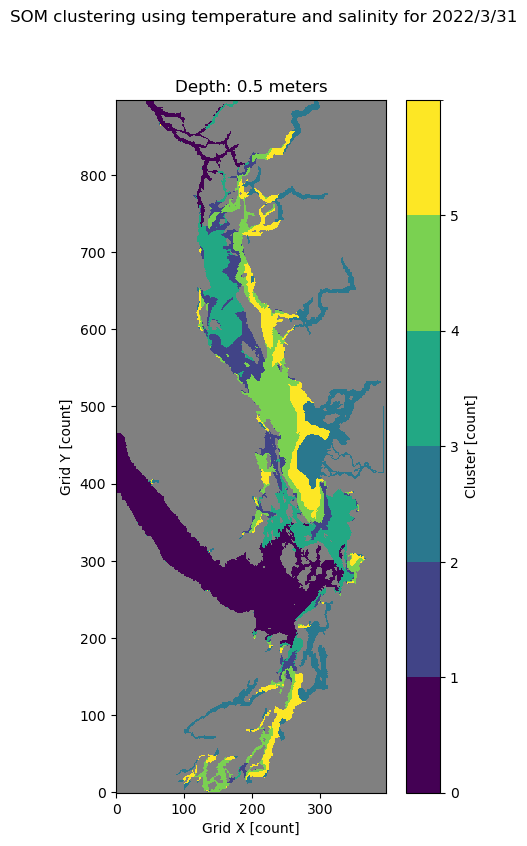

The amount of grid boxes for cluster 0 is 25390 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 28.97 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.41 g/kg 


The amount of grid boxes for cluster 1 is 11634 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.64 degrees Celsius 

The minimum salinity for cluster 1 is 27.23 g/kg
The maximum salinity for cluster 1 is 28.6 g/kg
The mean salinity for cluster 1 is 27.93 g/kg 


The amount of grid boxes for cluster 2 is 9026 

The minimum temperature for cluster 2 is 7.83 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 9.12 degrees Celsius 

Th

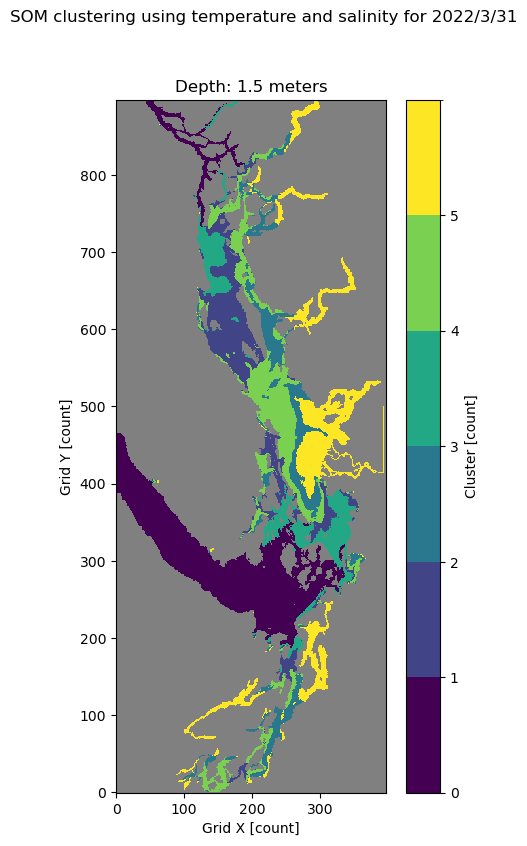

The amount of grid boxes for cluster 0 is 5886 

The minimum temperature for cluster 0 is 7.67 degrees Celsius
The maximum temperature for cluster 0 is 10.6 degrees Celsius
The mean temperature for cluster 0 is 9.05 degrees Celsius 

The minimum salinity for cluster 0 is 23.41 g/kg
The maximum salinity for cluster 0 is 25.57 g/kg
The mean salinity for cluster 0 is 24.61 g/kg 


The amount of grid boxes for cluster 1 is 16216 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 9.98 degrees Celsius
The mean temperature for cluster 1 is 8.55 degrees Celsius 

The minimum salinity for cluster 1 is 26.94 g/kg
The maximum salinity for cluster 1 is 28.53 g/kg
The mean salinity for cluster 1 is 27.77 g/kg 


The amount of grid boxes for cluster 2 is 25560 

The minimum temperature for cluster 2 is 6.73 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The

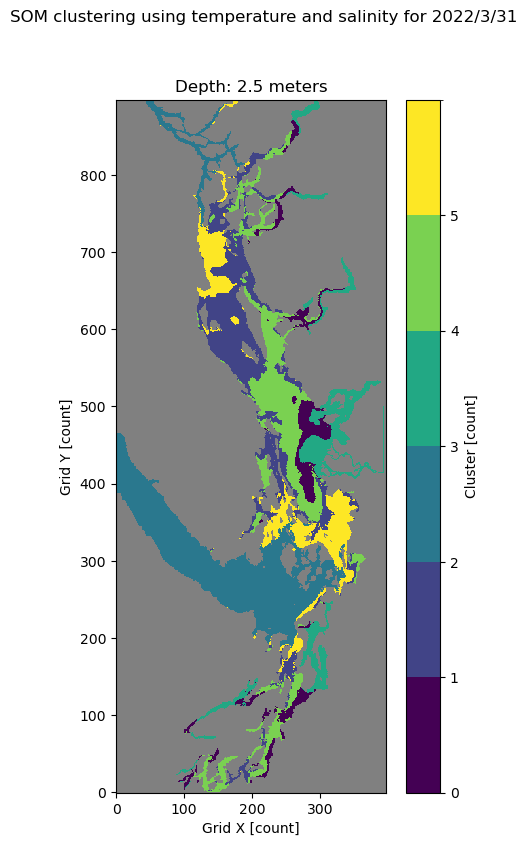

The amount of grid boxes for cluster 0 is 12340 

The minimum temperature for cluster 0 is 7.51 degrees Celsius
The maximum temperature for cluster 0 is 9.71 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 27.96 g/kg
The maximum salinity for cluster 0 is 29.11 g/kg
The mean salinity for cluster 0 is 28.47 g/kg 


The amount of grid boxes for cluster 1 is 12514 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.28 degrees Celsius
The mean temperature for cluster 1 is 8.7 degrees Celsius 

The minimum salinity for cluster 1 is 25.73 g/kg
The maximum salinity for cluster 1 is 27.13 g/kg
The mean salinity for cluster 1 is 26.58 g/kg 


The amount of grid boxes for cluster 2 is 6743 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.84 degrees Celsius
The mean temperature for cluster 2 is 8.78 degrees Celsius 

Th

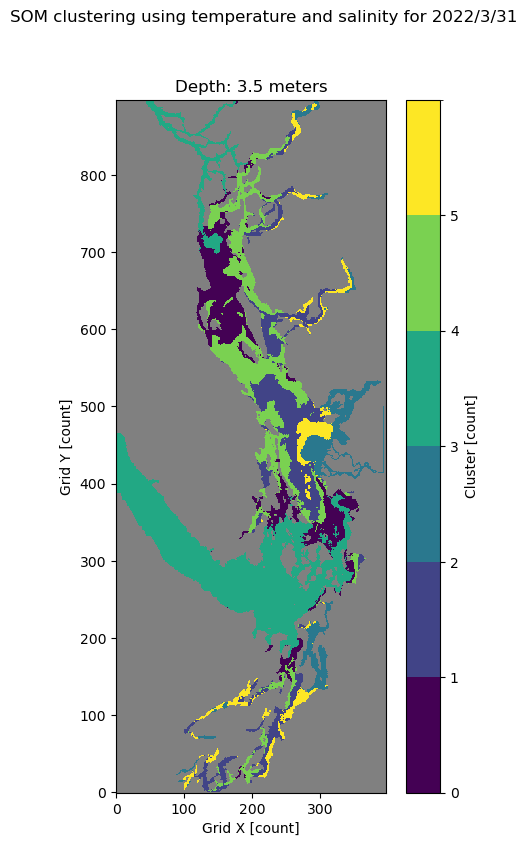

The amount of grid boxes for cluster 0 is 6421 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.64 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.74 g/kg
The mean salinity for cluster 0 is 21.59 g/kg 


The amount of grid boxes for cluster 1 is 11741 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 8.28 degrees Celsius 

The minimum salinity for cluster 1 is 27.78 g/kg
The maximum salinity for cluster 1 is 28.76 g/kg
The mean salinity for cluster 1 is 28.34 g/kg 


The amount of grid boxes for cluster 2 is 23971 

The minimum temperature for cluster 2 is 6.67 degrees Celsius
The maximum temperature for cluster 2 is 9.36 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The

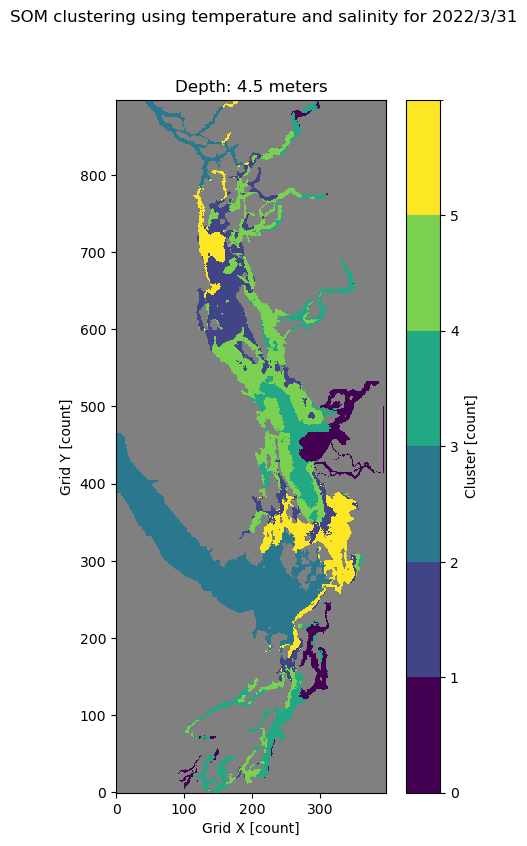

The amount of grid boxes for cluster 0 is 6784 

The minimum temperature for cluster 0 is 6.54 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 8.03 degrees Celsius 

The minimum salinity for cluster 0 is 29.05 g/kg
The maximum salinity for cluster 0 is 29.93 g/kg
The mean salinity for cluster 0 is 29.53 g/kg 


The amount of grid boxes for cluster 1 is 19458 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 27.44 g/kg
The maximum salinity for cluster 1 is 28.45 g/kg
The mean salinity for cluster 1 is 28.09 g/kg 


The amount of grid boxes for cluster 2 is 8307 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.32 degrees Celsius
The mean temperature for cluster 2 is 8.57 degrees Celsius 

Th

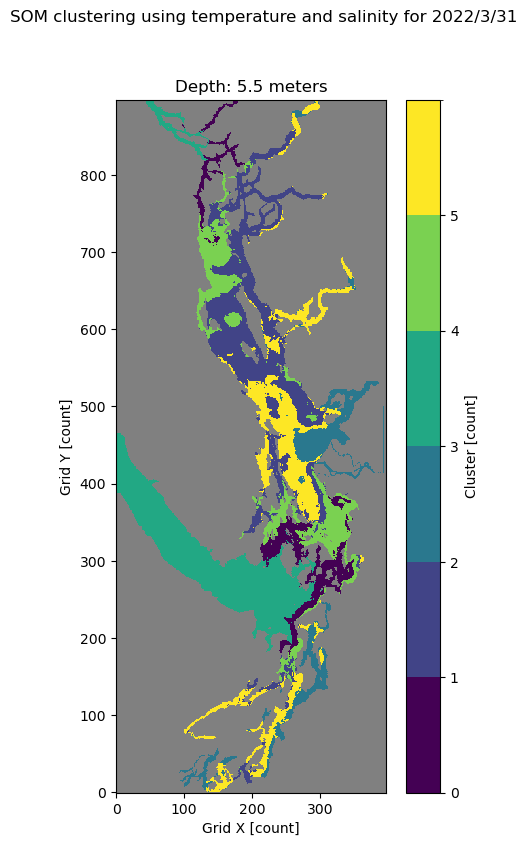

The amount of grid boxes for cluster 0 is 21446 

The minimum temperature for cluster 0 is 7.23 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.78 g/kg
The maximum salinity for cluster 0 is 31.42 g/kg
The mean salinity for cluster 0 is 30.63 g/kg 


The amount of grid boxes for cluster 1 is 7725 

The minimum temperature for cluster 1 is 7.81 degrees Celsius
The maximum temperature for cluster 1 is 9.09 degrees Celsius
The mean temperature for cluster 1 is 8.23 degrees Celsius 

The minimum salinity for cluster 1 is 28.68 g/kg
The maximum salinity for cluster 1 is 29.42 g/kg
The mean salinity for cluster 1 is 28.95 g/kg 


The amount of grid boxes for cluster 2 is 8939 

The minimum temperature for cluster 2 is 7.74 degrees Celsius
The maximum temperature for cluster 2 is 10.32 degrees Celsius
The mean temperature for cluster 2 is 8.52 degrees Celsius 

Th

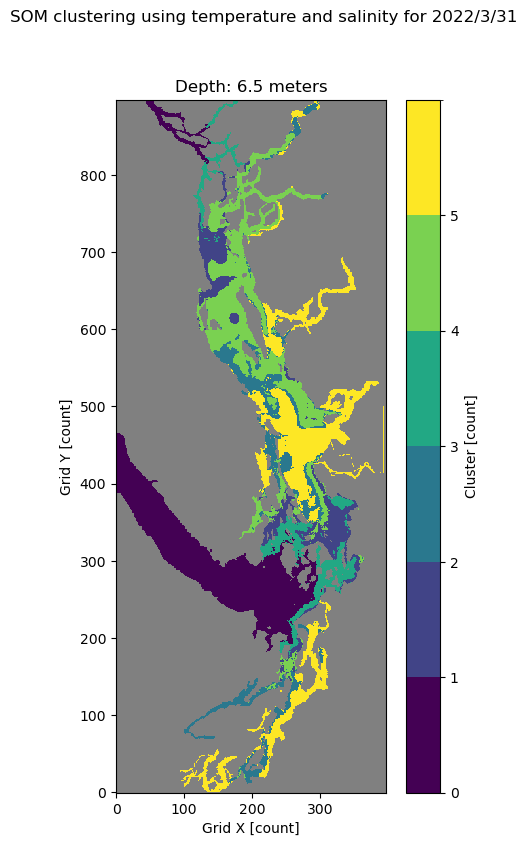

The amount of grid boxes for cluster 0 is 18876 

The minimum temperature for cluster 0 is 7.4 degrees Celsius
The maximum temperature for cluster 0 is 8.76 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 30.02 g/kg
The maximum salinity for cluster 0 is 31.44 g/kg
The mean salinity for cluster 0 is 30.73 g/kg 


The amount of grid boxes for cluster 1 is 6743 

The minimum temperature for cluster 1 is 6.53 degrees Celsius
The maximum temperature for cluster 1 is 8.91 degrees Celsius
The mean temperature for cluster 1 is 8.13 degrees Celsius 

The minimum salinity for cluster 1 is 28.99 g/kg
The maximum salinity for cluster 1 is 29.57 g/kg
The mean salinity for cluster 1 is 29.26 g/kg 


The amount of grid boxes for cluster 2 is 15839 

The minimum temperature for cluster 2 is 7.41 degrees Celsius
The maximum temperature for cluster 2 is 10.3 degrees Celsius
The mean temperature for cluster 2 is 8.24 degrees Celsius 

The 

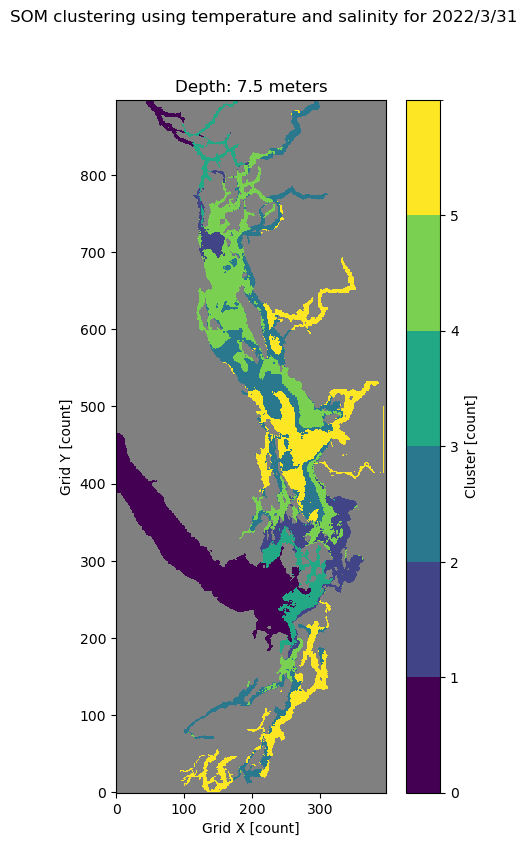

The amount of grid boxes for cluster 0 is 6372 

The minimum temperature for cluster 0 is 6.15 degrees Celsius
The maximum temperature for cluster 0 is 8.74 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 29.41 g/kg
The maximum salinity for cluster 0 is 30.07 g/kg
The mean salinity for cluster 0 is 29.73 g/kg 


The amount of grid boxes for cluster 1 is 17012 

The minimum temperature for cluster 1 is 7.49 degrees Celsius
The maximum temperature for cluster 1 is 10.27 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 28.23 g/kg
The maximum salinity for cluster 1 is 29.05 g/kg
The mean salinity for cluster 1 is 28.61 g/kg 


The amount of grid boxes for cluster 2 is 11175 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 9.86 degrees Celsius
The mean temperature for cluster 2 is 8.41 degrees Celsius 

T

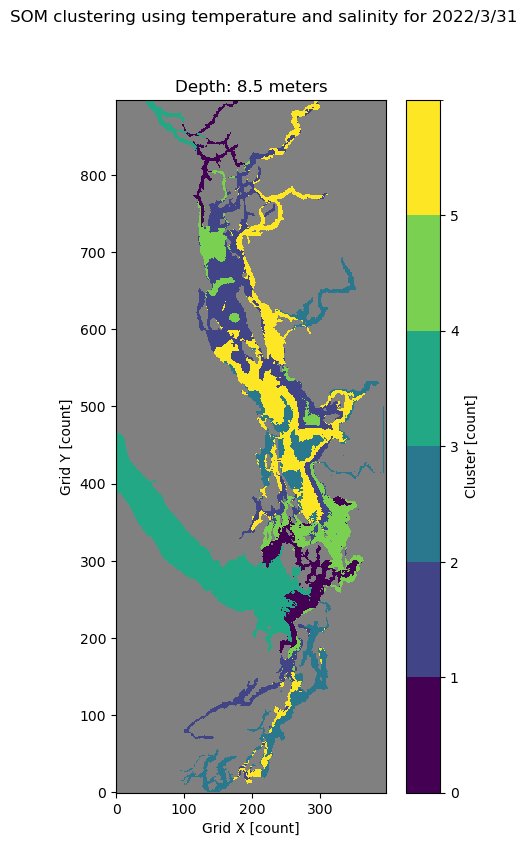

The amount of grid boxes for cluster 0 is 18810 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.03 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.58 g/kg
The mean salinity for cluster 0 is 27.78 g/kg 


The amount of grid boxes for cluster 1 is 15169 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 8.59 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 28.48 g/kg
The maximum salinity for cluster 1 is 29.09 g/kg
The mean salinity for cluster 1 is 28.75 g/kg 


The amount of grid boxes for cluster 2 is 5877 

The minimum temperature for cluster 2 is 6.16 degrees Celsius
The maximum temperature for cluster 2 is 8.63 degrees Celsius
The mean temperature for cluster 2 is 7.89 degrees Celsius 

The m

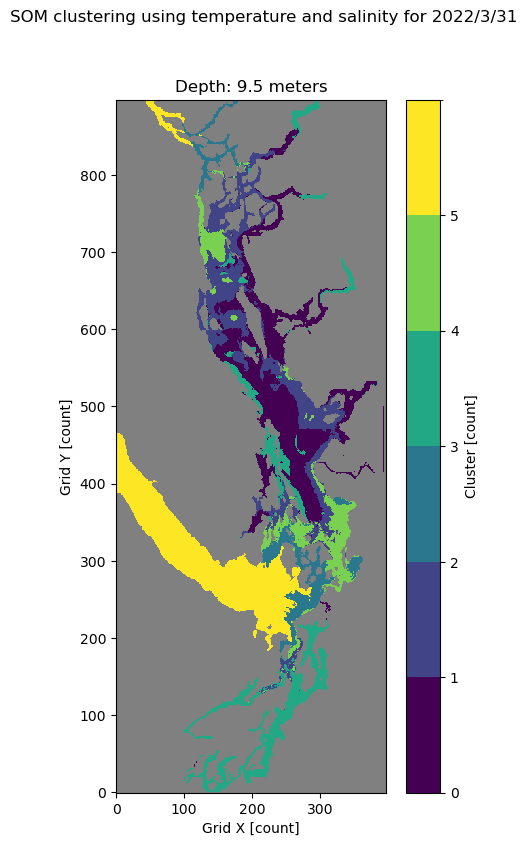

The amount of grid boxes for cluster 0 is 12585 

The minimum temperature for cluster 0 is 6.38 degrees Celsius
The maximum temperature for cluster 0 is 10.34 degrees Celsius
The mean temperature for cluster 0 is 8.63 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.25 g/kg
The mean salinity for cluster 0 is 27.68 g/kg 


The amount of grid boxes for cluster 1 is 5760 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 29.05 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.4 g/kg 


The amount of grid boxes for cluster 2 is 17311 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

The 

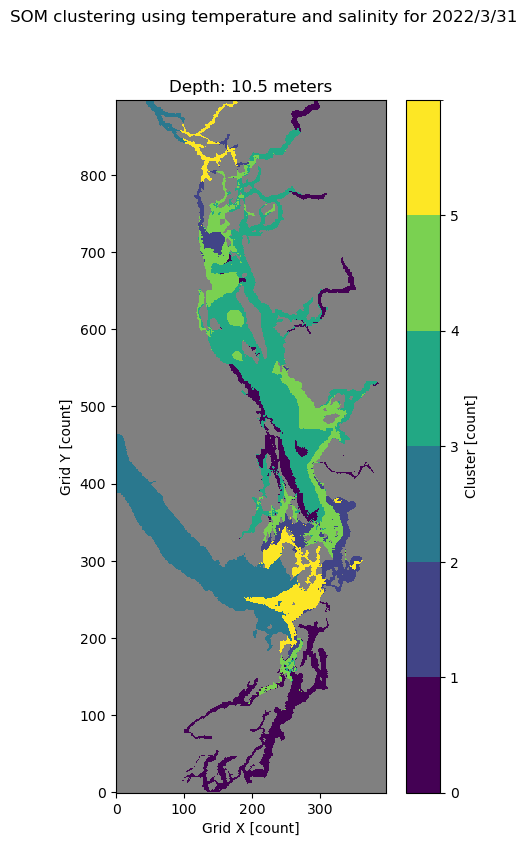

The amount of grid boxes for cluster 0 is 20507 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.24 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 27.93 g/kg
The maximum salinity for cluster 0 is 28.89 g/kg
The mean salinity for cluster 0 is 28.6 g/kg 


The amount of grid boxes for cluster 1 is 11252 

The minimum temperature for cluster 1 is 7.8 degrees Celsius
The maximum temperature for cluster 1 is 9.28 degrees Celsius
The mean temperature for cluster 1 is 8.14 degrees Celsius 

The minimum salinity for cluster 1 is 28.86 g/kg
The maximum salinity for cluster 1 is 29.3 g/kg
The mean salinity for cluster 1 is 29.04 g/kg 


The amount of grid boxes for cluster 2 is 5714 

The minimum temperature for cluster 2 is 6.32 degrees Celsius
The maximum temperature for cluster 2 is 8.64 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The mi

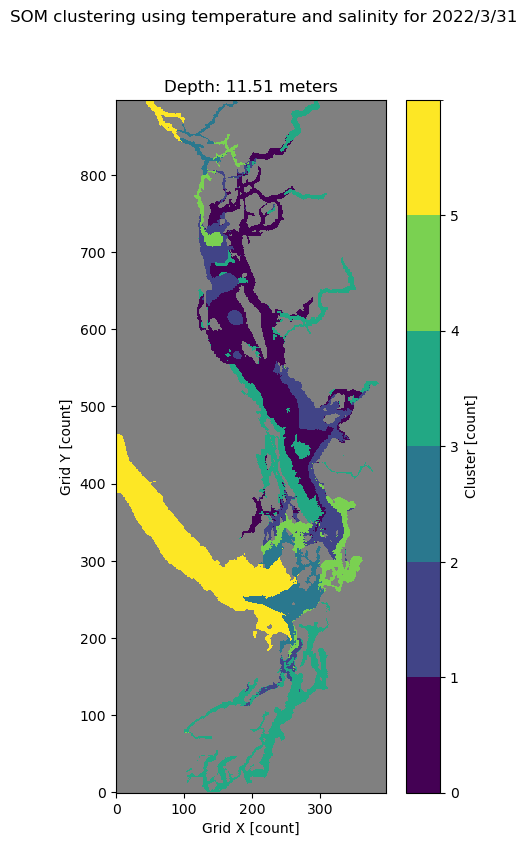

The amount of grid boxes for cluster 0 is 9751 

The minimum temperature for cluster 0 is 8.13 degrees Celsius
The maximum temperature for cluster 0 is 10.5 degrees Celsius
The mean temperature for cluster 0 is 8.76 degrees Celsius 

The minimum salinity for cluster 0 is 26.56 g/kg
The maximum salinity for cluster 0 is 29.4 g/kg
The mean salinity for cluster 0 is 28.6 g/kg 


The amount of grid boxes for cluster 1 is 5586 

The minimum temperature for cluster 1 is 7.72 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.74 g/kg
The mean salinity for cluster 1 is 29.35 g/kg 


The amount of grid boxes for cluster 2 is 19605 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 

The m

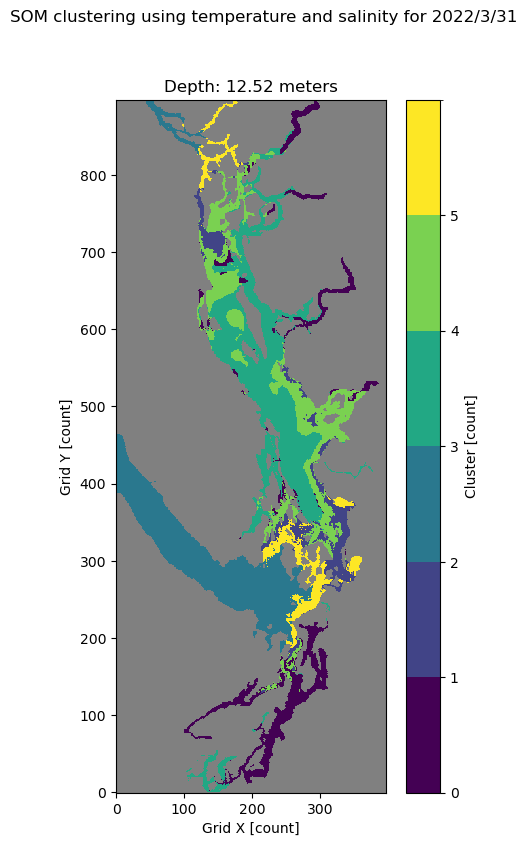

The amount of grid boxes for cluster 0 is 5440 

The minimum temperature for cluster 0 is 6.56 degrees Celsius
The maximum temperature for cluster 0 is 8.3 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.7 g/kg
The maximum salinity for cluster 0 is 30.39 g/kg
The mean salinity for cluster 0 is 30.07 g/kg 


The amount of grid boxes for cluster 1 is 12086 

The minimum temperature for cluster 1 is 7.83 degrees Celsius
The maximum temperature for cluster 1 is 8.99 degrees Celsius
The mean temperature for cluster 1 is 8.17 degrees Celsius 

The minimum salinity for cluster 1 is 28.96 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.15 g/kg 


The amount of grid boxes for cluster 2 is 11199 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.73 degrees Celsius 

The

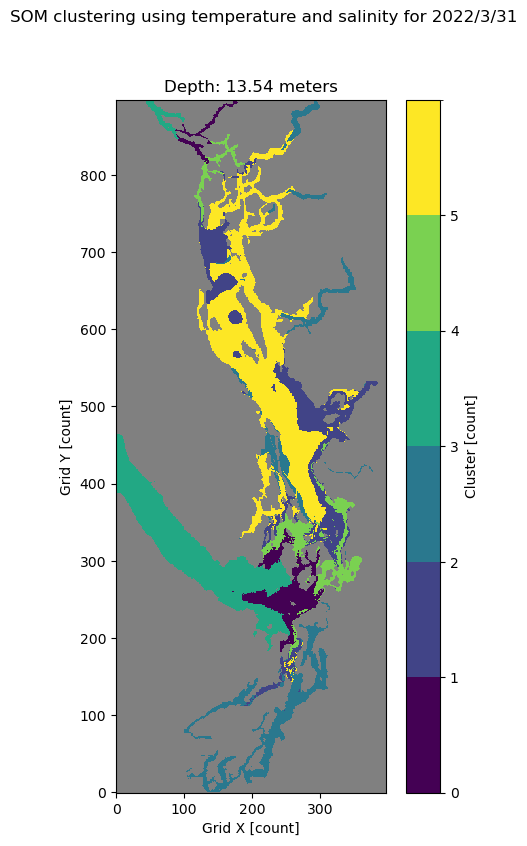

The amount of grid boxes for cluster 0 is 21055 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.23 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 28.12 g/kg
The maximum salinity for cluster 0 is 29.08 g/kg
The mean salinity for cluster 0 is 28.73 g/kg 


The amount of grid boxes for cluster 1 is 5650 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.58 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.73 g/kg
The mean salinity for cluster 1 is 29.48 g/kg 


The amount of grid boxes for cluster 2 is 17242 

The minimum temperature for cluster 2 is 7.22 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 7.82 degrees Celsius 

Th

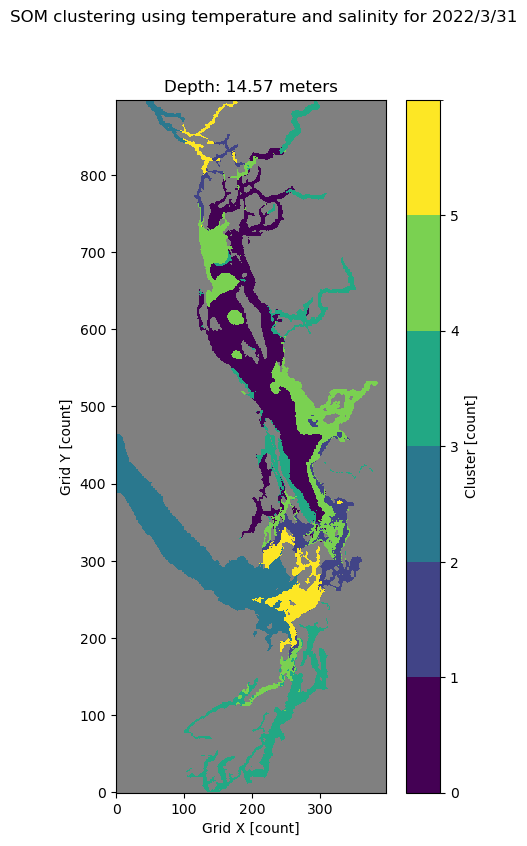

The amount of grid boxes for cluster 0 is 15324 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 8.26 degrees Celsius
The mean temperature for cluster 0 is 7.8 degrees Celsius 

The minimum salinity for cluster 0 is 30.42 g/kg
The maximum salinity for cluster 0 is 31.78 g/kg
The mean salinity for cluster 0 is 30.96 g/kg 


The amount of grid boxes for cluster 1 is 5337 

The minimum temperature for cluster 1 is 6.8 degrees Celsius
The maximum temperature for cluster 1 is 8.4 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.27 g/kg
The maximum salinity for cluster 1 is 29.97 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 23920 

The minimum temperature for cluster 2 is 7.36 degrees Celsius
The maximum temperature for cluster 2 is 8.23 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The mi

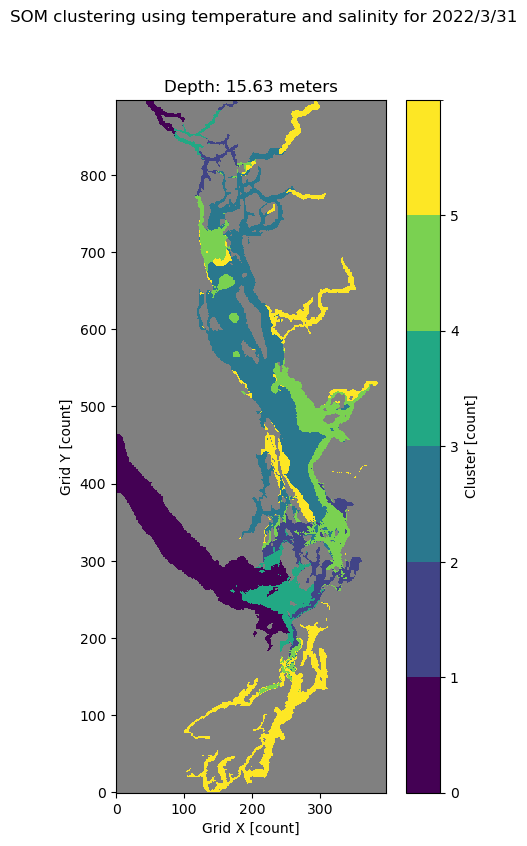

The amount of grid boxes for cluster 0 is 22335 

The minimum temperature for cluster 0 is 7.35 degrees Celsius
The maximum temperature for cluster 0 is 8.26 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 27.4 g/kg
The maximum salinity for cluster 0 is 29.16 g/kg
The mean salinity for cluster 0 is 28.82 g/kg 


The amount of grid boxes for cluster 1 is 6812 

The minimum temperature for cluster 1 is 7.56 degrees Celsius
The maximum temperature for cluster 1 is 8.37 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 29.16 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.49 g/kg 


The amount of grid boxes for cluster 2 is 17064 

The minimum temperature for cluster 2 is 7.17 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.8 degrees Celsius 

The 

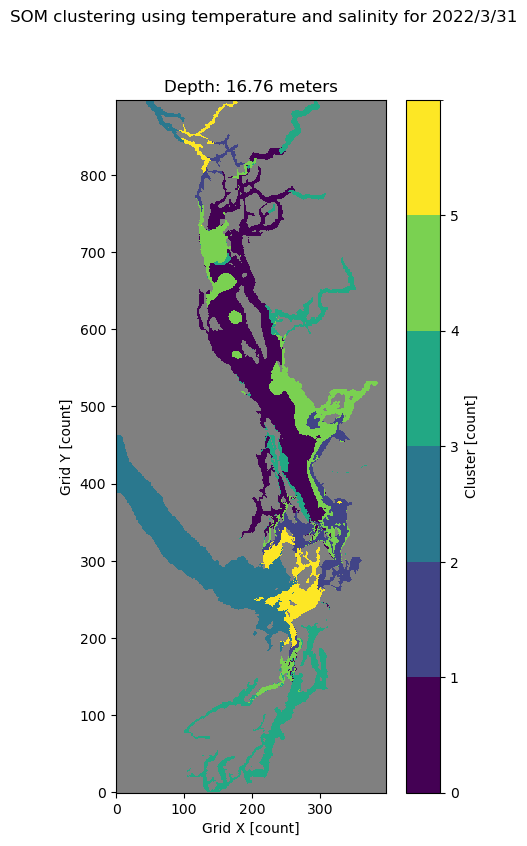

The amount of grid boxes for cluster 0 is 15397 

The minimum temperature for cluster 0 is 7.16 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.78 degrees Celsius 

The minimum salinity for cluster 0 is 30.44 g/kg
The maximum salinity for cluster 0 is 31.89 g/kg
The mean salinity for cluster 0 is 30.99 g/kg 


The amount of grid boxes for cluster 1 is 4369 

The minimum temperature for cluster 1 is 7.06 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.36 g/kg
The maximum salinity for cluster 1 is 29.98 g/kg
The mean salinity for cluster 1 is 29.7 g/kg 


The amount of grid boxes for cluster 2 is 25473 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 9.13 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The

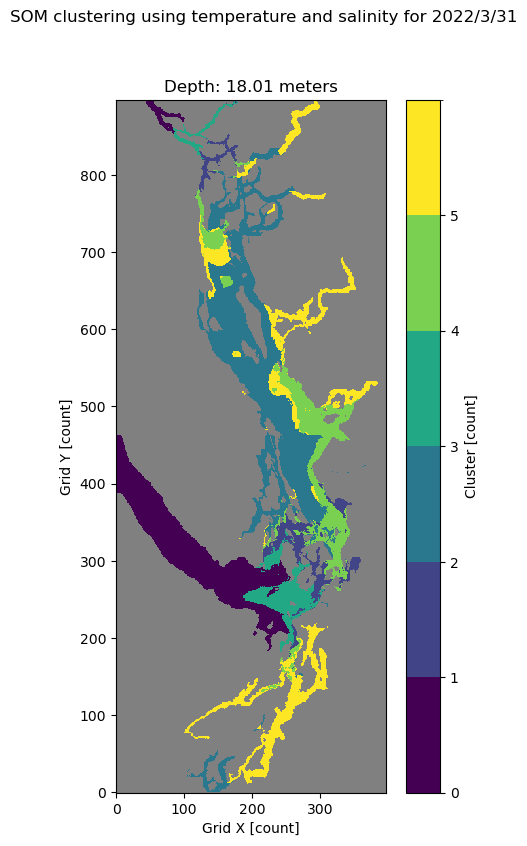

The amount of grid boxes for cluster 0 is 26216 

The minimum temperature for cluster 0 is 6.49 degrees Celsius
The maximum temperature for cluster 0 is 9.13 degrees Celsius
The mean temperature for cluster 0 is 8.02 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.28 g/kg
The mean salinity for cluster 0 is 28.86 g/kg 


The amount of grid boxes for cluster 1 is 9174 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.42 degrees Celsius
The mean temperature for cluster 1 is 8.02 degrees Celsius 

The minimum salinity for cluster 1 is 29.22 g/kg
The maximum salinity for cluster 1 is 29.71 g/kg
The mean salinity for cluster 1 is 29.45 g/kg 


The amount of grid boxes for cluster 2 is 4542 

The minimum temperature for cluster 2 is 7.24 degrees Celsius
The maximum temperature for cluster 2 is 8.07 degrees Celsius
The mean temperature for cluster 2 is 7.84 degrees Celsius 

The m

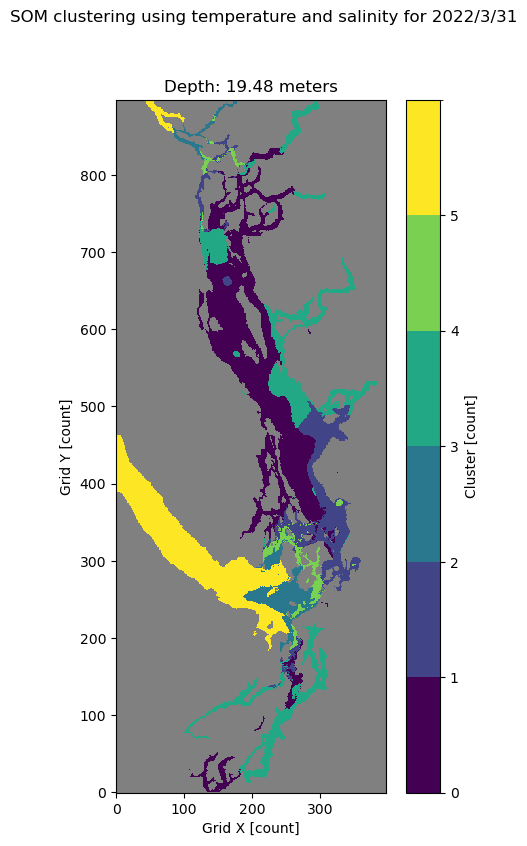

The amount of grid boxes for cluster 0 is 4962 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 29.8 g/kg
The maximum salinity for cluster 0 is 30.46 g/kg
The mean salinity for cluster 0 is 30.15 g/kg 


The amount of grid boxes for cluster 1 is 11090 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 21463 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.02 degrees Celsius 

The

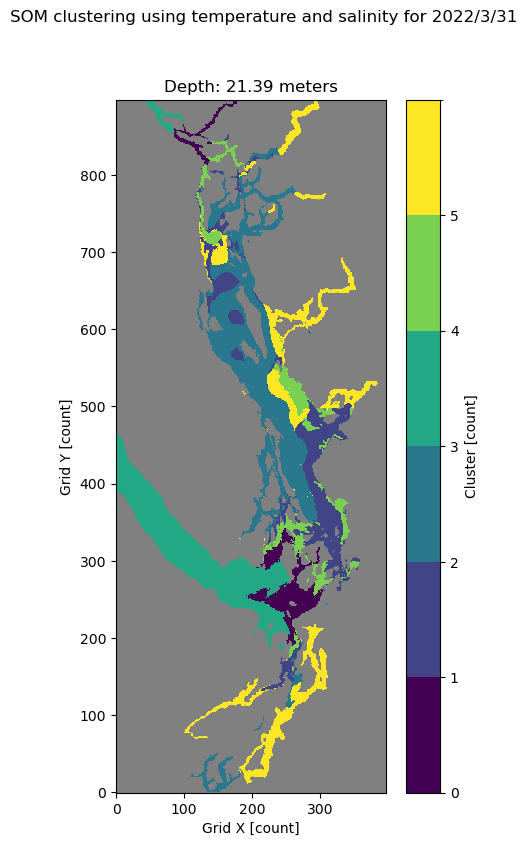

The amount of grid boxes for cluster 0 is 14191 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.73 degrees Celsius 

The minimum salinity for cluster 0 is 30.6 g/kg
The maximum salinity for cluster 0 is 32.22 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 2099 

The minimum temperature for cluster 1 is 7.64 degrees Celsius
The maximum temperature for cluster 1 is 8.68 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.63 g/kg
The maximum salinity for cluster 1 is 30.15 g/kg
The mean salinity for cluster 1 is 29.94 g/kg 


The amount of grid boxes for cluster 2 is 12745 

The minimum temperature for cluster 2 is 8.28 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.81 degrees Celsius 

The

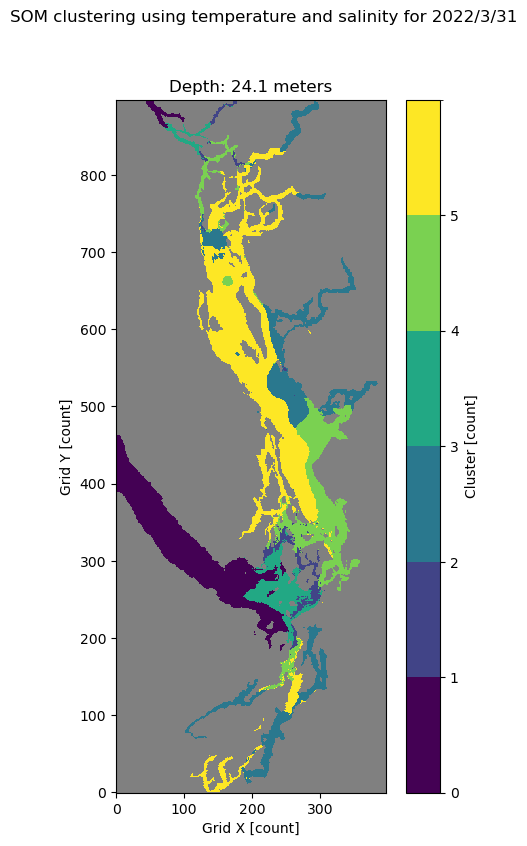

The amount of grid boxes for cluster 0 is 3999 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 7.99 degrees Celsius
The mean temperature for cluster 0 is 7.79 degrees Celsius 

The minimum salinity for cluster 0 is 29.97 g/kg
The maximum salinity for cluster 0 is 30.73 g/kg
The mean salinity for cluster 0 is 30.48 g/kg 


The amount of grid boxes for cluster 1 is 9594 

The minimum temperature for cluster 1 is 7.65 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.37 g/kg
The maximum salinity for cluster 1 is 29.9 g/kg
The mean salinity for cluster 1 is 29.61 g/kg 


The amount of grid boxes for cluster 2 is 26130 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.8 degrees Celsius
The mean temperature for cluster 2 is 8.14 degrees Celsius 

The mi

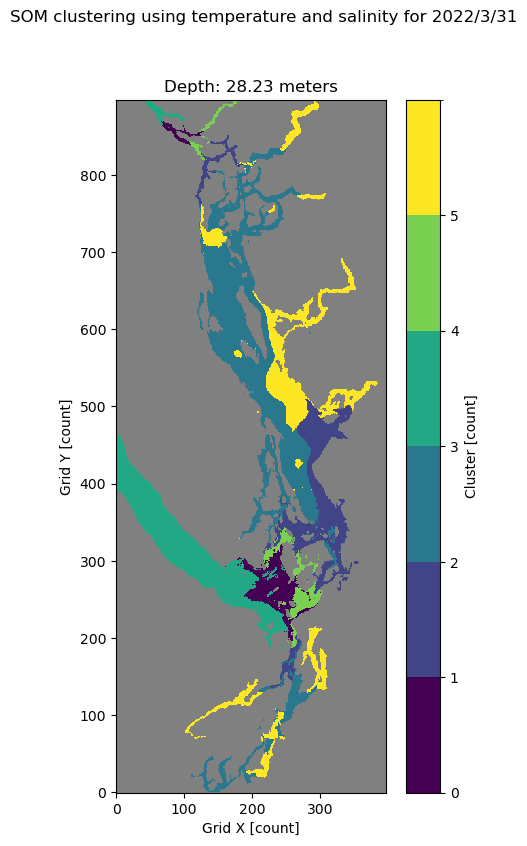

The amount of grid boxes for cluster 0 is 4471 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 7.99 degrees Celsius
The mean temperature for cluster 0 is 7.76 degrees Celsius 

The minimum salinity for cluster 0 is 29.99 g/kg
The maximum salinity for cluster 0 is 30.84 g/kg
The mean salinity for cluster 0 is 30.57 g/kg 


The amount of grid boxes for cluster 1 is 10189 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 29.38 g/kg
The maximum salinity for cluster 1 is 29.95 g/kg
The mean salinity for cluster 1 is 29.68 g/kg 


The amount of grid boxes for cluster 2 is 23208 

The minimum temperature for cluster 2 is 7.63 degrees Celsius
The maximum temperature for cluster 2 is 8.78 degrees Celsius
The mean temperature for cluster 2 is 8.21 degrees Celsius 

Th

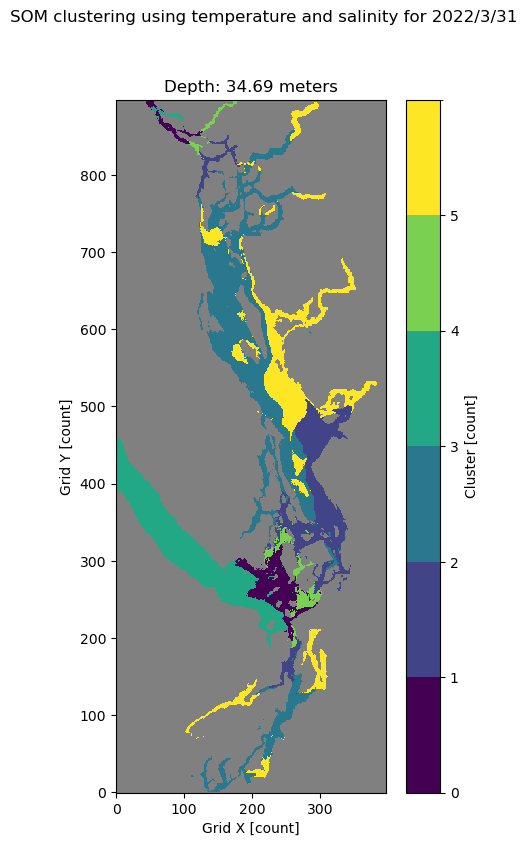

The amount of grid boxes for cluster 0 is 13786 

The minimum temperature for cluster 0 is 8.38 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.37 g/kg
The maximum salinity for cluster 0 is 30.38 g/kg
The mean salinity for cluster 0 is 29.82 g/kg 


The amount of grid boxes for cluster 1 is 1388 

The minimum temperature for cluster 1 is 8.09 degrees Celsius
The maximum temperature for cluster 1 is 8.88 degrees Celsius
The mean temperature for cluster 1 is 8.26 degrees Celsius 

The minimum salinity for cluster 1 is 29.79 g/kg
The maximum salinity for cluster 1 is 30.35 g/kg
The mean salinity for cluster 1 is 29.89 g/kg 


The amount of grid boxes for cluster 2 is 3873 

The minimum temperature for cluster 2 is 7.43 degrees Celsius
The maximum temperature for cluster 2 is 7.93 degrees Celsius
The mean temperature for cluster 2 is 7.73 degrees Celsius 

Th

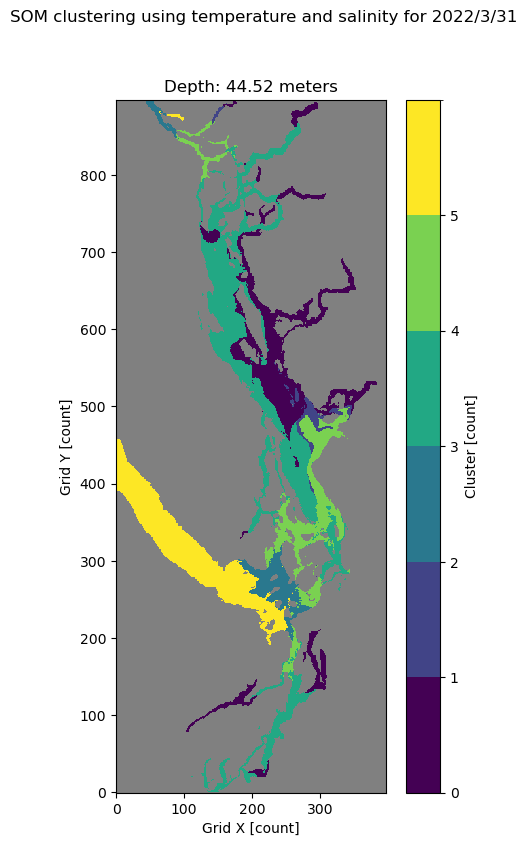

The amount of grid boxes for cluster 0 is 15445 

The minimum temperature for cluster 0 is 7.62 degrees Celsius
The maximum temperature for cluster 0 is 8.66 degrees Celsius
The mean temperature for cluster 0 is 8.32 degrees Celsius 

The minimum salinity for cluster 0 is 27.44 g/kg
The maximum salinity for cluster 0 is 30.05 g/kg
The mean salinity for cluster 0 is 29.61 g/kg 


The amount of grid boxes for cluster 1 is 9683 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.31 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.53 g/kg
The maximum salinity for cluster 1 is 30.35 g/kg
The mean salinity for cluster 1 is 29.93 g/kg 


The amount of grid boxes for cluster 2 is 3901 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 7.83 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The

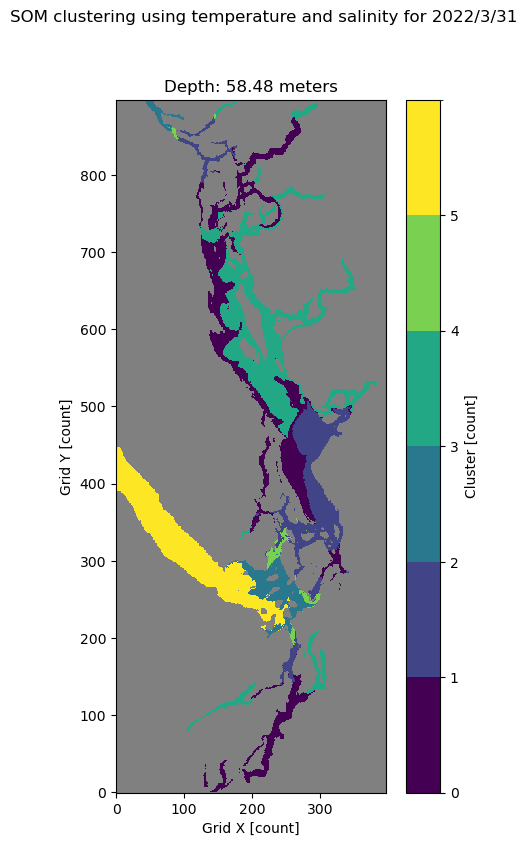

The amount of grid boxes for cluster 0 is 9588 

The minimum temperature for cluster 0 is 7.64 degrees Celsius
The maximum temperature for cluster 0 is 8.72 degrees Celsius
The mean temperature for cluster 0 is 8.31 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 30.18 g/kg
The mean salinity for cluster 0 is 29.75 g/kg 


The amount of grid boxes for cluster 1 is 10891 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.42 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 29.62 g/kg
The maximum salinity for cluster 1 is 30.54 g/kg
The mean salinity for cluster 1 is 30.04 g/kg 


The amount of grid boxes for cluster 2 is 3049 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 7.75 degrees Celsius
The mean temperature for cluster 2 is 7.61 degrees Celsius 

The 

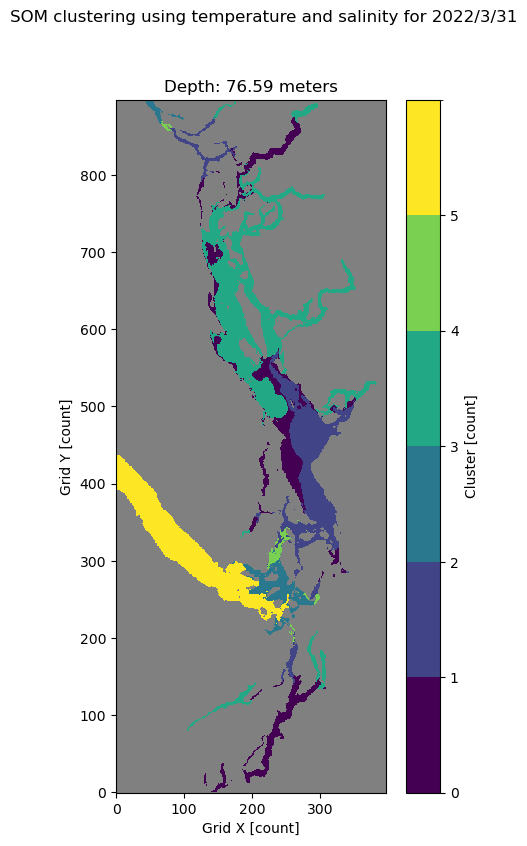

The amount of grid boxes for cluster 0 is 7985 

The minimum temperature for cluster 0 is 7.07 degrees Celsius
The maximum temperature for cluster 0 is 7.5 degrees Celsius
The mean temperature for cluster 0 is 7.21 degrees Celsius 

The minimum salinity for cluster 0 is 32.66 g/kg
The maximum salinity for cluster 0 is 33.55 g/kg
The mean salinity for cluster 0 is 33.19 g/kg 


The amount of grid boxes for cluster 1 is 650 

The minimum temperature for cluster 1 is 7.52 degrees Celsius
The maximum temperature for cluster 1 is 7.68 degrees Celsius
The mean temperature for cluster 1 is 7.6 degrees Celsius 

The minimum salinity for cluster 1 is 31.03 g/kg
The maximum salinity for cluster 1 is 31.61 g/kg
The mean salinity for cluster 1 is 31.3 g/kg 


The amount of grid boxes for cluster 2 is 17538 

The minimum temperature for cluster 2 is 8.42 degrees Celsius
The maximum temperature for cluster 2 is 10.48 degrees Celsius
The mean temperature for cluster 2 is 8.89 degrees Celsius 

The mi

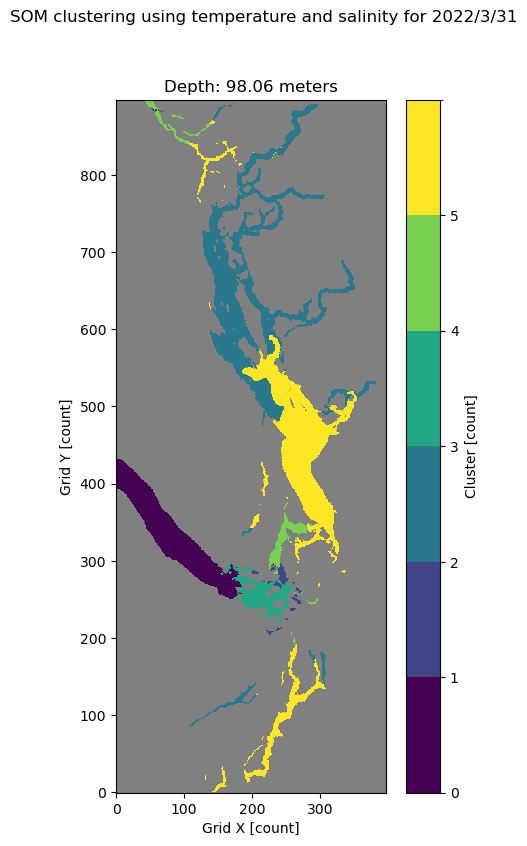

The amount of grid boxes for cluster 0 is 8591 

The minimum temperature for cluster 0 is 6.94 degrees Celsius
The maximum temperature for cluster 0 is 7.47 degrees Celsius
The mean temperature for cluster 0 is 7.17 degrees Celsius 

The minimum salinity for cluster 0 is 31.94 g/kg
The maximum salinity for cluster 0 is 33.68 g/kg
The mean salinity for cluster 0 is 33.21 g/kg 


The amount of grid boxes for cluster 1 is 16 

The minimum temperature for cluster 1 is 7.67 degrees Celsius
The maximum temperature for cluster 1 is 7.69 degrees Celsius
The mean temperature for cluster 1 is 7.68 degrees Celsius 

The minimum salinity for cluster 1 is 30.8 g/kg
The maximum salinity for cluster 1 is 30.82 g/kg
The mean salinity for cluster 1 is 30.81 g/kg 


The amount of grid boxes for cluster 2 is 13011 

The minimum temperature for cluster 2 is 8.65 degrees Celsius
The maximum temperature for cluster 2 is 10.64 degrees Celsius
The mean temperature for cluster 2 is 9.04 degrees Celsius 

The m

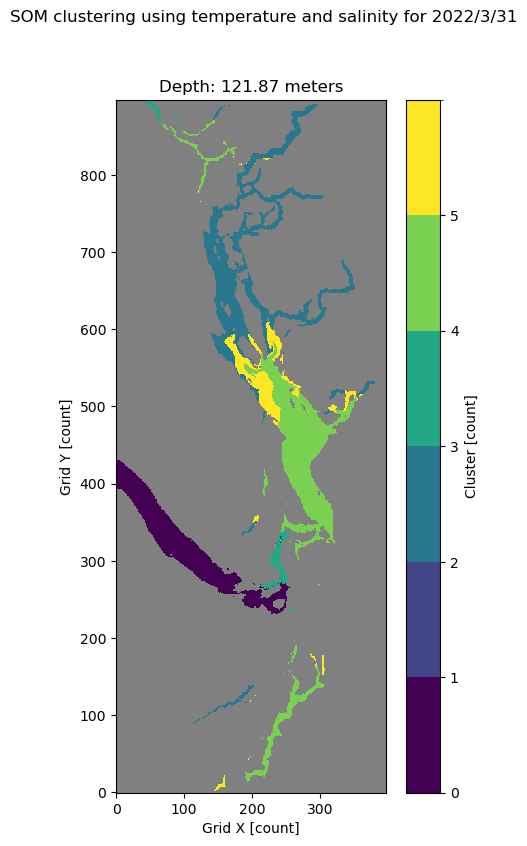

The amount of grid boxes for cluster 0 is 3021 

The minimum temperature for cluster 0 is 8.19 degrees Celsius
The maximum temperature for cluster 0 is 8.69 degrees Celsius
The mean temperature for cluster 0 is 8.46 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 30.61 g/kg
The mean salinity for cluster 0 is 30.43 g/kg 


The amount of grid boxes for cluster 1 is 10751 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 8.24 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 29.09 g/kg
The maximum salinity for cluster 1 is 30.88 g/kg
The mean salinity for cluster 1 is 30.32 g/kg 


The amount of grid boxes for cluster 2 is 862 

The minimum temperature for cluster 2 is 7.3 degrees Celsius
The maximum temperature for cluster 2 is 7.68 degrees Celsius
The mean temperature for cluster 2 is 7.6 degrees Celsius 

The min

IndexError: index 5 is out of bounds for axis 0 with size 5

In [7]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
